<a href="https://colab.research.google.com/github/khanfs/pan-coronavirus-antivirals/blob/main/SARS_P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Virtual Screening of SARS-CoV Candidate Compounds** 

##**Exploratory Data Analysis**
Filter pharmacokinetic properties of SARS-CoV candidate molecules by [ADME](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4110820/), [lead-likeness](https://www.sciencedirect.com/science/article/pii/B9780123741943000123) and [Lipinski's rule of five](https://dev.drugbank.com/guides/terms/lipinski-s-rule-of-five) (Ro5) criteria. Keep only orally bioavailable compounds. Ro5 estimates the [bioavailability](https://www.ncbi.nlm.nih.gov/books/NBK557852/) of compounds according to their chemical structure. Probability of poor absorption increases if chemical structures violate one or more of the **Ro5 rules**:   

* Molecular weight (MWT) <= 500 Da
* Number of hydrogen bond acceptors (HBAs) <= 10
* Number of hydrogen bond donors (HBD) <= 5
* Calculated LogP (octanol-water coefficient) <= 5


In [1]:
# Import packages, modules and libraries 
from pathlib import Path
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

In [2]:
# Install NBVAL
! pip install nbval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import nbval

In [4]:
# Install RDKit
! pip install rdkit-pypi -qqq

     |████████████████████████████████| 22.7 MB 20.9 MB/s 


In [5]:
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw, PandasTools

In [6]:
# Set path to this notebook
HERE = Path(_dh[-1])
DATA = HERE / "data"

In [7]:
molecules = pd.read_csv(HERE / "..//content/SARS-CoV-1_Compounds.csv", index_col=0)
print(molecules.shape)
molecules.head()

(152, 4)


,IC50,units,smiles,pIC50
molecule_chembl_id,,,,
CHEMBL2441741,230.0,nM,CC(C)C[C@H](NC(=O)[C@H](Cc1cccc2ccccc12)NC(=O)...,6.638272
CHEMBL221366,500.0,nM,O=C(Oc1cccnc1)c1cccs1,6.301030
CHEMBL2441745,610.0,nM,CC(C)C[C@H](NC(=O)[C@H](Cc1cccc2ccccc12)NC(=O)...,6.214670
CHEMBL1876821,940.0,nM,CN(CC(=O)NC1CCCC1)S(=O)(=O)c1cccc(Cl)c1,6.026872
CHEMBL3099526,1040.0,nM,CC1CCN(S(=O)(=O)c2ccc3c(c2)C(=O)C(=O)N3C)CC1,5.982967


###**1. Apply Ro5 to SARS-CoV Molecule Candidates**

In [8]:
# Apply Ro5 function calculate_r05_properties to molecules
def calculate_ro5_properties(smiles):
    """
    Test if input molecule (SMILES) fulfills Lipinski's rule of five.

    Parameters
    ----------
    smiles : str
        SMILES for a molecule.

    Returns
    -------
    pandas.Series
        Molecular weight, number of hydrogen bond acceptors/donor and logP value
        and Lipinski's rule of five compliance for input molecule.
    """
    # RDKit molecule from SMILES
    molecule = Chem.MolFromSmiles(smiles)
    # Calculate Ro5-relevant chemical properties
    molecular_weight = Descriptors.ExactMolWt(molecule)
    n_hba = Descriptors.NumHAcceptors(molecule)
    n_hbd = Descriptors.NumHDonors(molecule)
    logp = Descriptors.MolLogP(molecule)
    # Check if Ro5 conditions fulfilled
    conditions = [molecular_weight <= 500, n_hba <= 10, n_hbd <= 5, logp <= 5]
    ro5_fulfilled = sum(conditions) >= 3
    # Return True if no more than one out of four conditions is violated
    return pd.Series(
        [molecular_weight, n_hba, n_hbd, logp, ro5_fulfilled],
        index=["molecular_weight", "n_hba", "n_hbd", "logp", "ro5_fulfilled"],
    )


In [9]:
ro5_properties = molecules["smiles"].apply(calculate_ro5_properties)
ro5_properties.head()

,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
molecule_chembl_id,,,,,
CHEMBL2441741,600.294785,6,4,3.4181,True
CHEMBL221366,205.019749,4,0,2.3623,True
CHEMBL2441745,685.347549,7,5,3.3129,True
CHEMBL1876821,330.080491,3,1,2.0193,True
CHEMBL3099526,322.098728,4,0,1.2663,True


In [10]:
# Concatenate molecules with Ro5 data
molecules = pd.concat([molecules, ro5_properties], axis=1)
molecules.head()

,IC50,units,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
molecule_chembl_id,,,,,,,,,
CHEMBL2441741,230.0,nM,CC(C)C[C@H](NC(=O)[C@H](Cc1cccc2ccccc12)NC(=O)...,6.638272,600.294785,6,4,3.4181,True
CHEMBL221366,500.0,nM,O=C(Oc1cccnc1)c1cccs1,6.301030,205.019749,4,0,2.3623,True
CHEMBL2441745,610.0,nM,CC(C)C[C@H](NC(=O)[C@H](Cc1cccc2ccccc12)NC(=O)...,6.214670,685.347549,7,5,3.3129,True
CHEMBL1876821,940.0,nM,CN(CC(=O)NC1CCCC1)S(=O)(=O)c1cccc(Cl)c1,6.026872,330.080491,3,1,2.0193,True
CHEMBL3099526,1040.0,nM,CC1CCN(S(=O)(=O)c2ccc3c(c2)C(=O)C(=O)N3C)CC1,5.982967,322.098728,4,0,1.2663,True


In [11]:
# Note that the column "ro5_fulfilled" contains boolean values.
# Thus, we can use the column values directly to subset data.
# Note that ~ negates boolean values.
molecules_ro5_fulfilled = molecules[molecules["ro5_fulfilled"]]
molecules_ro5_violated = molecules[~molecules["ro5_fulfilled"]]

print(f"# compounds in unfiltered data set: {molecules.shape[0]}")
print(f"# compounds in filtered data set: {molecules_ro5_fulfilled.shape[0]}")
print(f"# compounds not compliant with the Ro5: {molecules_ro5_violated.shape[0]}")
# NBVAL_CHECK_OUTPUT

# compounds in unfiltered data set: 152
# compounds in filtered data set: 129
# compounds not compliant with the Ro5: 23


In [12]:
# Save filtered data
molecules_ro5_fulfilled.to_csv("SARS_compounds_lipinski.csv")
molecules_ro5_fulfilled.head()

,IC50,units,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
molecule_chembl_id,,,,,,,,,
CHEMBL2441741,230.0,nM,CC(C)C[C@H](NC(=O)[C@H](Cc1cccc2ccccc12)NC(=O)...,6.638272,600.294785,6,4,3.4181,True
CHEMBL221366,500.0,nM,O=C(Oc1cccnc1)c1cccs1,6.301030,205.019749,4,0,2.3623,True
CHEMBL2441745,610.0,nM,CC(C)C[C@H](NC(=O)[C@H](Cc1cccc2ccccc12)NC(=O)...,6.214670,685.347549,7,5,3.3129,True
CHEMBL1876821,940.0,nM,CN(CC(=O)NC1CCCC1)S(=O)(=O)c1cccc(Cl)c1,6.026872,330.080491,3,1,2.0193,True
CHEMBL3099526,1040.0,nM,CC1CCN(S(=O)(=O)c2ccc3c(c2)C(=O)C(=O)N3C)CC1,5.982967,322.098728,4,0,1.2663,True


###**2. Calculate Statistical Ro5 Properties** 

In [13]:
# Define a helper function to calculate the mean and standard deviation for an input DataFrame
def calculate_mean_std(dataframe):
    """
    Calculate the mean and standard deviation of a dataset.

    Parameters
    ----------
    dataframe : pd.DataFrame
        Properties (columns) for a set of items (rows).

    Returns
    -------
    pd.DataFrame
        Mean and standard deviation (columns) for different properties (rows).
    """
    # Generate descriptive statistics for property columns
    stats = dataframe.describe()
    # Transpose DataFrame (statistical measures = columns)
    stats = stats.T
    # Select mean and standard deviation
    stats = stats[["mean", "std"]]
    return stats

###**Calculate statistics of compounds that satisfy Ro5**

In [14]:
molecules_ro5_fulfilled_stats = calculate_mean_std(
    molecules_ro5_fulfilled[["molecular_weight", "n_hba", "n_hbd", "logp"]]
)
molecules_ro5_fulfilled_stats
# NBVAL_CHECK_OUTPUT

,mean,std
molecular_weight,413.441777,101.219728
n_hba,5.186047,2.192913
n_hbd,1.821705,1.553472
logp,3.147502,2.312134


###**Calculate statistics of compounds that violate Ro5**

In [15]:
molecules_ro5_violated_stats = calculate_mean_std(
    molecules_ro5_violated[["molecular_weight", "n_hba", "n_hbd", "logp"]]
)
molecules_ro5_violated_stats

,mean,std
molecular_weight,582.440841,69.314208
n_hba,9.086957,3.800874
n_hbd,6.130435,4.003457
logp,3.189830,4.645712


###**3. Visualise Ro5 Properties**

####**Define helper functions to prepare data for radar plotting**

**Prepare y values**: Ro5 data is of different magnitudes; rescale Ro5 data to a scale threshold of 5 to evaluate variables equally:

    scaled property value = property value / property threshold * scaled property threshold

* scaled MWT = MWT / 500 * 5 = MWT / 100
* scaled HBA = HBA / 10 * 5 = HBA / 2
* scaled HBD = HBD / 5 * 5 = HBD
* scaled LogP = LogP / 5 * 5 = LogP

This results in a downscaling of the MWT by 100, HBA by 2, while HBD and LogP stay unchanged.

In [16]:
def _scale_by_thresholds(stats, thresholds, scaled_threshold):
    """
    Scale values for different properties that have each an individually defined threshold.

    Parameters
    ----------
    stats : pd.DataFrame
        Dataframe with "mean" and "std" (columns) for each physicochemical property (rows).
    thresholds : dict of str: int
        Thresholds defined for each property.
    scaled_threshold : int or float
        Scaled thresholds across all properties.

    Returns
    -------
    pd.DataFrame
        DataFrame with scaled means and standard deviations for each physiochemical property.
    """
    # Raise error if scaling keys and data_stats indicies are not matching
    for property_name in stats.index:
        if property_name not in thresholds.keys():
            raise KeyError(f"Add property '{property_name}' to scaling variable.")
    # Scale property data
    stats_scaled = stats.apply(lambda x: x / thresholds[x.name] * scaled_threshold, axis=1)
    return stats_scaled

**Prepare x values**: Construct helper function to return physicochemical property axes as a radar chart; axes set at 0°, 90°, 180°, and 270°; function returns angles as radians. 

In [17]:
def _define_radial_axes_angles(n_axes):
    """Define angles (radians) for radial (x-)axes depending on the number of axes."""
    x_angles = [i / float(n_axes) * 2 * math.pi for i in range(n_axes)]
    x_angles += x_angles[:1]
    return x_angles

**[Generate](https://stackoverflow.com/questions/42227409/tutorial-for-python-radar-chart-plot) Radar Plots:**

1. Compounds that satisfy the Ro5 
2. Compounds that violate the Ro5

In [18]:
def plot_radar(
    y,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max=None,
    output_path=None,
):
    """
    Plot a radar chart based on the mean and standard deviation of a data set's properties.

    Parameters
    ----------
    y : pd.DataFrame
        Dataframe with "mean" and "std" (columns) for each physicochemical property (rows).
    thresholds : dict of str: int
        Thresholds defined for each property.
    scaled_threshold : int or float
        Scaled thresholds across all properties.
    properties_labels : list of str
        List of property names to be used as labels in the plot.
    y_max : None or int or float
        Set maximum y value. If None, let matplotlib decide.
    output_path : None or pathlib.Path
        If not None, save plot to file.
    """

    # Define radial x-axes angles -- uses our helper function!
    x = _define_radial_axes_angles(len(y))
    # Scale y-axis values with respect to a defined threshold -- uses our helper function!
    y = _scale_by_thresholds(y, thresholds, scaled_threshold)
    # Since our chart will be circular we append the first value of each property to the end
    y = y.append(y.iloc[0])

    # Set figure and subplot axis
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)

    # Plot data
    ax.fill(x, [scaled_threshold] * 5, "cornflowerblue", alpha=0.2)
    ax.plot(x, y["mean"], "b", lw=3, ls="-")
    ax.plot(x, y["mean"] + y["std"], "orange", lw=2, ls="--")
    ax.plot(x, y["mean"] - y["std"], "orange", lw=2, ls="-.")

    # From here on, we only do plot cosmetics
    # Set 0° to 12 o'clock
    ax.set_theta_offset(math.pi / 2)
    # Set clockwise rotation
    ax.set_theta_direction(-1)

    # Set y-labels next to 180° radius axis
    ax.set_rlabel_position(180)
    # Set number of radial axes' ticks and remove labels
    plt.xticks(x, [])
    # Get maximal y-ticks value
    if not y_max:
        y_max = int(ax.get_yticks()[-1])
    # Set axes limits
    plt.ylim(0, y_max)
    # Set number and labels of y axis ticks
    plt.yticks(
        range(1, y_max),
        ["5" if i == scaled_threshold else "" for i in range(1, y_max)],
        fontsize=16,
    )

    # Draw ytick labels to make sure they fit properly
    # Note that we use [:1] to exclude the last element which equals the first element (not needed here)
    for i, (angle, label) in enumerate(zip(x[:-1], properties_labels)):
        if angle == 0:
            ha = "center"
        elif 0 < angle < math.pi:
            ha = "left"
        elif angle == math.pi:
            ha = "center"
        else:
            ha = "right"
        ax.text(
            x=angle,
            y=y_max + 1,
            s=label,
            size=16,
            horizontalalignment=ha,
            verticalalignment="center",
        )

    # Add legend relative to top-left plot
    labels = ("mean", "mean + std", "mean - std", "rule of five area")
    ax.legend(labels, loc=(1.1, 0.7), labelspacing=0.3, fontsize=16)

    # Save plot - use bbox_inches to include text boxes
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches="tight", transparent=True)

    plt.show()

In [19]:
# Define input parameters for radar charts
thresholds = {"molecular_weight": 500, "n_hba": 10, "n_hbd": 5, "logp": 5}
scaled_threshold = 5
properties_labels = [
    "Molecular weight (Da) / 100",
    "# HBA / 2",
    "# HBD",
    "LogP",
]
y_max = 8

###**3.1 Compounds that satisfy the Ro5**

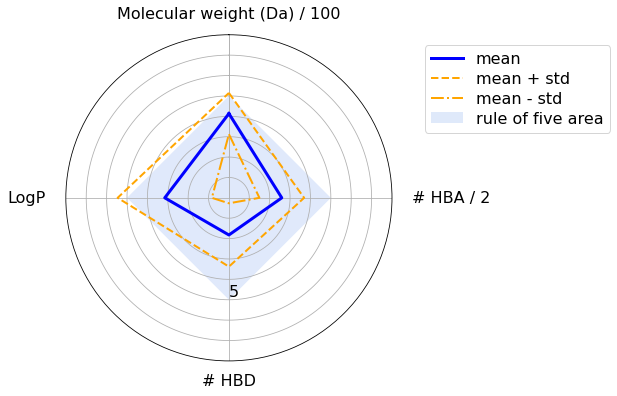

In [20]:
plot_radar(
    molecules_ro5_fulfilled_stats,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max,
)

* **Light blue square**: shows the area where a molecule’s physicochemical properties are compliant with the Ro5 
* **Dark blue line**: highlights the mean values
* **Orange dashed lines**: show the standard deviations +/-

###**3.2 Plot radarplot of compounds that violate the Ro5**

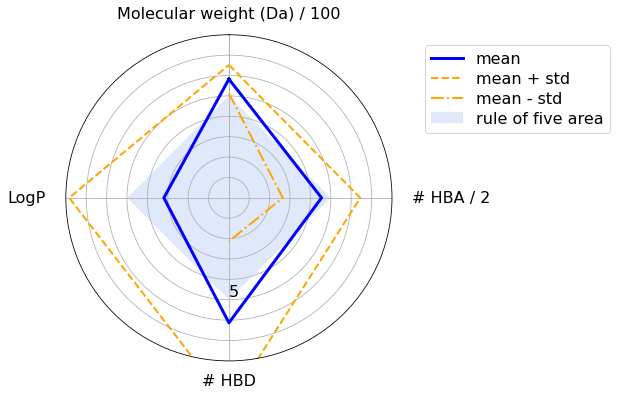

In [21]:
plot_radar(
    molecules_ro5_violated_stats,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max,
)

##**4. Further Screening Research**
###**SwissADME**

[SwissADME](http://www.swissadme.ch/index.php) allows us to compute physicochemical descriptors as well as to predict ADME parameters, pharmacokinetic properties, druglike nature and medicinal chemistry friendliness of one or multiple small molecules to support drug discovery. However, currently there is no API, molecules have to be manualy entered on SwissADME. Highlighted is example, molecule 2 from our dataset: 

In [22]:
from IPython.display import Image

In [23]:
Image(url="http://www.swissadme.ch/results/521723204/molecule1/radar.png", width = 400, height = 400)

In [24]:
# Displaying images from Github repo requires changing github.com to raw.githubusercontent and remove blob from url
Image(url='https://raw.githubusercontent.com/xai-bio/pan-coronavirus-antivirals/main/images/SwissADME1_Molecule2_SARS1.png')

In [25]:
Image(url='https://raw.githubusercontent.com/xai-bio/pan-coronavirus-antivirals/main/images/SwissADME2_Molecule2_SARS1.png')

####**BOILED-Egg**
Apart from efficacy and toxicity, many drug development failures are imputable to poor pharmacokinetics and bioavailability. Gastrointestinal absorption and brain access are two pharmacokinetic behaviors crucial to estimate at various stages of the drug discovery processes. To this end, the **Brain Or IntestinaL EstimateD permeation method (BOILED-Egg)** is proposed as an accurate predictive model that works by computing the lipophilicity and polarity of small molecules (Daina A, Zoete V, 2016).

In [26]:
Image(url='https://raw.githubusercontent.com/xai-bio/pan-coronavirus-antivirals/main/images/BOILED-Egg_Molecule2_SARS1.png')

**References**:
* Daina, A., Michielin, O. & Zoete, V. **SwissADME: a free web tool to evaluate pharmacokinetics, drug-likeness and medicinal chemistry friendliness of small molecules**. Sci Rep 7, 42717 (2017). https://doi.org/10.1038/srep42717
* Daina A, Zoete V. **A BOILED-Egg To Predict Gastrointestinal Absorption and Brain Penetration of Small Molecules**. ChemMedChem. 2016 Jun 6;11(11):1117-21. doi: 10.1002/cmdc.201600182. Epub 2016 May 24. PMID: 27218427; PMCID: PMC5089604.
* Clark AM, Dole K, Coulon-Spektor A, McNutt A, Grass G, Freundlich JS, Reynolds RC, Ekins S. **Open Source Bayesian Models. 1. Application to ADME/Tox and Drug Discovery Datasets**. J Chem Inf Model. 2015 Jun 22;55(6):1231-45. doi: 10.1021/acs.jcim.5b00143. Epub 2015 Jun 3. PMID: 25994950; PMCID: PMC4478615.